In [169]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:
import warnings

import numpy as np
import gsw
import xarray as xr
from xgcm import Grid
from xhistogram.xarray import histogram
from dask.diagnostics import ProgressBar

import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import regionmask

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean

import cartopy.crs as ccrs
import cartopy.feature as cfeature
data_crs = ccrs.PlateCarree()

In [201]:
import sys
sys.path.append("../")
import xwmb.pottemp as xwmb

In [202]:
import dask

In [203]:
import sectionate as sec

### Load grids and data

In [174]:
# Load data on native grid
dt = '6hourly'
rootdir = '/archive/gam/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/ocean_'+dt+'/'
gridname = 'zstr'
prefix = '19000101.ocean_'+dt+'_'
time = "1900_*" # '1900_02_*' # Just month two?

# Diagnostics were saved into different files
suffixs = ['thck','heat','salt','xtra']
ds = xr.Dataset()
for suffix in suffixs:
    filename = prefix+gridname+'_'+suffix+'_'+time+'*.nc'
    dsnow = xr.open_mfdataset(rootdir+filename)
    ds = xr.merge([ds,dsnow])
    
# Load snapshot data (for mass tendency term)
suffix = 'snap'
filename = prefix+gridname+'_'+suffix+'_'+time+'*.nc'
snap = xr.open_mfdataset(rootdir+filename)

#  Load grid
gridname = '19000101.ocean_static.nc'
grid = xr.open_dataset(rootdir+gridname).squeeze()

# Cut off the first time-averaged entry in ds, because snap does not come with the initial condition
ds = ds.isel(time=slice(1,None)).chunk({'time':1})

# Some renaming to match hdrake conventions
ocean_grid = grid.copy().rename({'depth_ocean':'deptho'})
ds = ds.rename({'temp':'thetao'})
snap = snap.rename({'temp':'thetao'})

# z-coordinate dataset containing basic state variables
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'},
                        'Z': {'center': 'z_l', 'outer': 'z_i'} },
           periodic=None)

# z-coordinate dataset containing basic state variables
grid_snap = Grid(snap, coords={'X': {'center': 'xh',},
                        'Y': {'center': 'yh',},
                        'Z': {'center': 'z_l', 'outer': 'z_i'} },
           periodic=None)

In [175]:
#ds = ds.isel(time=[0])
#snap = snap.isel(time=[0,1])

# Full-domain (arbitrary domain method)

In [176]:
geolon_c, geolat_c = np.zeros((ocean_grid.yh.size+1, ocean_grid.xh.size+1)), np.zeros(((ocean_grid.yh.size+1, ocean_grid.xh.size+1)))
geolon_c[1:,1:] = ocean_grid.geolon_c.data
geolon_c[0, :] = geolon_c[1, :]
geolon_c[:, 0] = geolon_c[:, 1] - (geolon_c[:, 2] - geolon_c[:, 1]) 
geolat_c[1:,1:] = ocean_grid.geolat_c.data
geolat_c[:, 0] = geolat_c[:, 1]
geolat_c[0, :] = geolat_c[1, :] - (geolat_c[2, :] - geolat_c[1, :])

geolon_u, geolat_u = np.zeros((ocean_grid.yh.size, ocean_grid.xh.size+1)), np.zeros(((ocean_grid.yh.size, ocean_grid.xh.size+1)))
geolon_u[:,1:] = ocean_grid.geolon_u.data
geolon_u[:, 0] = geolon_u[:, 1] - (geolon_u[:, 2] - geolon_u[:, 1])
geolat_u[:,1:] = ocean_grid.geolat_u.data
geolat_u[:, 0] = geolat_u[:, 1]

geolon_v, geolat_v = np.zeros((ocean_grid.yh.size+1, ocean_grid.xh.size)), np.zeros(((ocean_grid.yh.size+1, ocean_grid.xh.size)))
geolon_v[1:,:] = ocean_grid.geolon_v.data
geolon_v[0, :] = geolon_v[1, :] - (geolon_v[2, :] - geolon_v[1, :])
geolat_v[1:,:] = ocean_grid.geolat_v.data
geolat_v[0, :] = geolat_v[1, :]

In [177]:
xx = np.array([
    ocean_grid['geolon_c'].isel(xq=0, yq=0),
    ocean_grid['geolon_c'].isel(xq=-1, yq=0),
    ocean_grid['geolon_c'].isel(xq=-1, yq=-1),
    ocean_grid['geolon_c'].isel(xq=0, yq=-1)])
yy = np.array([
    ocean_grid['geolat_c'].isel(xq=0, yq=0),
    ocean_grid['geolat_c'].isel(xq=-1, yq=0),
    ocean_grid['geolat_c'].isel(xq=-1, yq=-1),
    ocean_grid['geolat_c'].isel(xq=0, yq=-1)])

In [178]:
i, j, x, y = sec.create_section_composite(
    ocean_grid['geolon_c'],
    ocean_grid['geolat_c'],
    np.append(xx, xx[0]),
    np.append(yy, yy[0]),
    closed=True,
)

polygon_geom = Polygon(zip(x, y))
crs = 'epsg:4326'
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])

region_mask = ~np.isnan(regionmask.mask_geopandas(polygon, ocean_grid['geolon'], lat=ocean_grid['geolat'], wrap_lon='360'))

symmetric = ocean_grid['geolon'].shape==ocean_grid['geolon_c'].shape
uvpoints = sec.transports_C.MOM6_UVpoints_from_section(i, j, symmetric=symmetric)

uv_lons, uv_lats = sec.transports_C.MOM6_UVcoords_from_points_uv(
    ocean_grid['geolon_u'],
    ocean_grid['geolat_u'],
    ocean_grid['geolon_v'],
    ocean_grid['geolat_v'],
    uvpoints,
    symmetric=symmetric
)

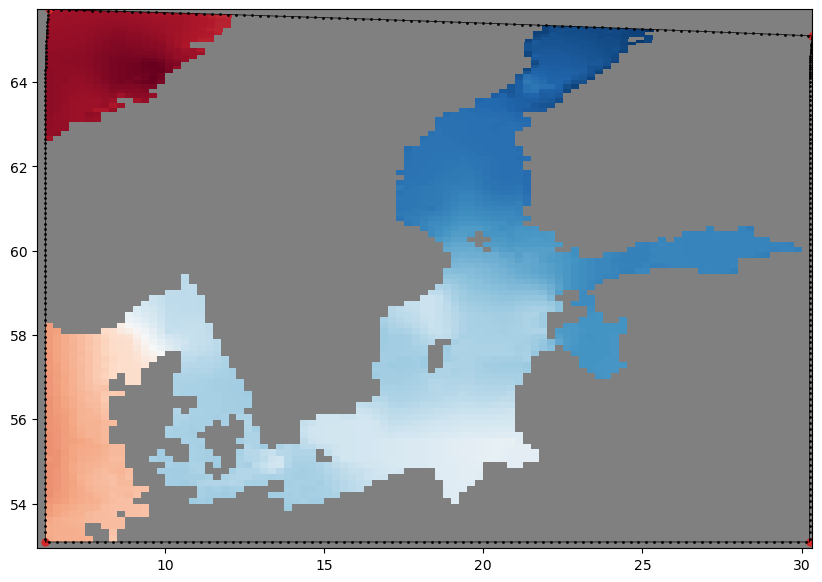

In [179]:
plt.figure(figsize=(10, 7))
plt.subplot(facecolor="grey")
da_plot = ds['thetao'].isel(time=0, z_l=0).where(region_mask)
vmin, vmax = da_plot.min().values, da_plot.max().values
pc = plt.pcolormesh(
    geolon_c, geolat_c,
    da_plot,
    alpha=1.0, cmap="RdBu_r",
    vmin=vmin, vmax=vmax
)
plt.plot(xx, yy, "C3o", markersize=5)
plt.plot(x, y, "k-", linewidth=0.5)
plt.plot(uv_lons, uv_lats, "k.", markersize=2.)

In [180]:
wmb_square = xwmb.wmb.calc_wmb_theta(
    ds, grid, snap, grid_snap, ocean_grid,
    region_mask, i, j
)

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` sho

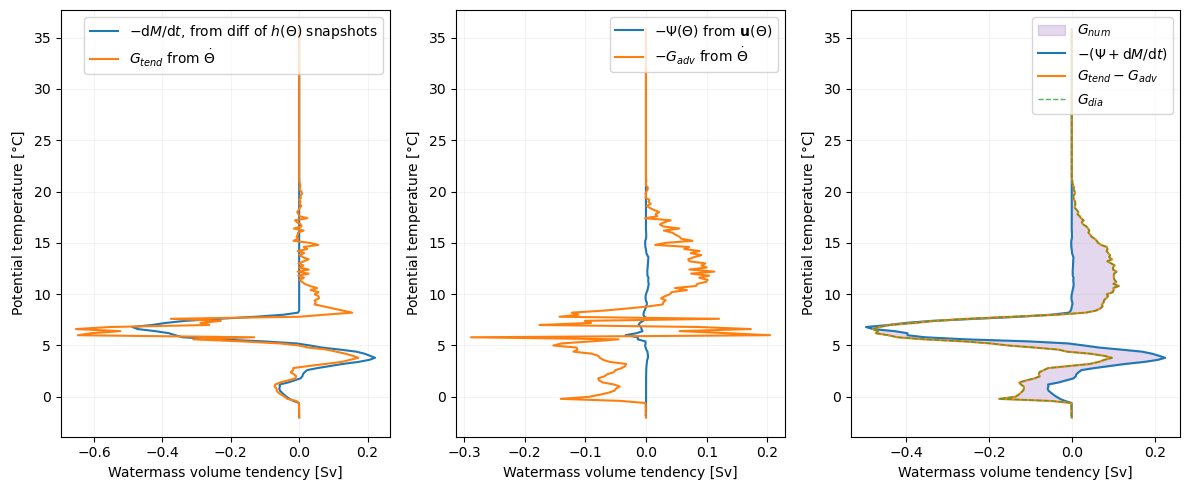

In [225]:
xwmb.wmb.plot_wmb(wmb_square)

# Arbitrary sub-domain

In [226]:
xx = np.array([13, 18, 20.5, 21.5, 18.25, 17])
yy = np.array([54., 53.5, 54.5, 57.1, 56.75, 59])

In [227]:
i, j, x, y = sec.create_section_composite(
    ocean_grid['geolon_c'],
    ocean_grid['geolat_c'],
    np.append(xx, xx[0]),
    np.append(yy, yy[0]),
    closed=True
)

polygon_geom = Polygon(zip(x, y))
crs = 'epsg:4326'
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])

region_mask = ~np.isnan(regionmask.mask_geopandas(polygon, ocean_grid['geolon'], lat=ocean_grid['geolat'], wrap_lon='360'))

symmetric = ocean_grid['geolon'].shape==ocean_grid['geolon_c'].shape
uvpoints = sec.transports_C.MOM6_UVpoints_from_section(i, j, symmetric=symmetric)

uv_lons, uv_lats = sec.transports_C.MOM6_UVcoords_from_points_uv(
    ocean_grid['geolon_u'],
    ocean_grid['geolat_u'],
    ocean_grid['geolon_v'],
    ocean_grid['geolat_v'],
    uvpoints,
    symmetric=symmetric
)

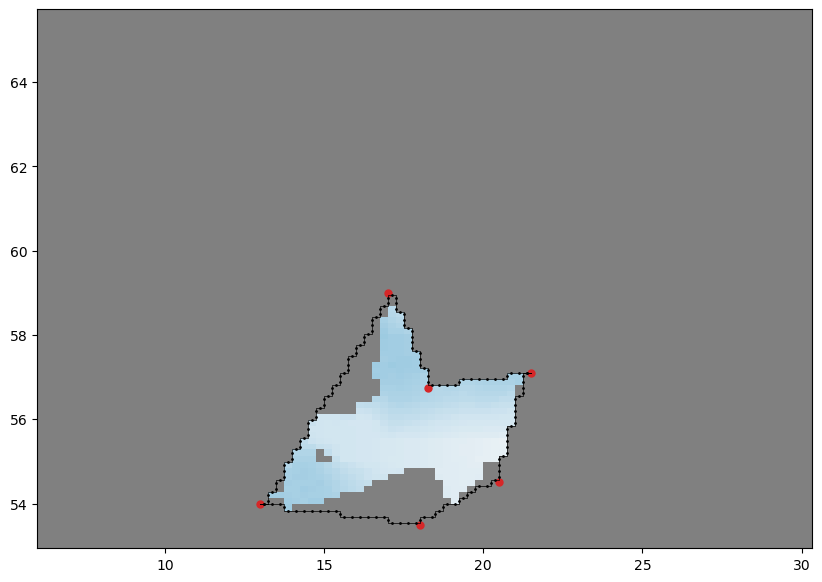

In [228]:
plt.figure(figsize=(10, 7))
plt.subplot(facecolor="grey")
da_plot = ds['thetao'].isel(time=0, z_l=0).where(region_mask)
pc = plt.pcolormesh(
    geolon_c, geolat_c,
    da_plot,
    alpha=1.0, cmap="RdBu_r",
    vmin=vmin, vmax=vmax
)
plt.plot(xx, yy, "C3o", markersize=5)
plt.plot(x, y, "k-", linewidth=0.5)
plt.plot(uv_lons, uv_lats, "k.", markersize=2.)

In [185]:
wmb_polygon = xwmb.wmb.calc_wmb_theta(
    ds, grid, snap, grid_snap, ocean_grid,
    region_mask, i, j
)

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` sho

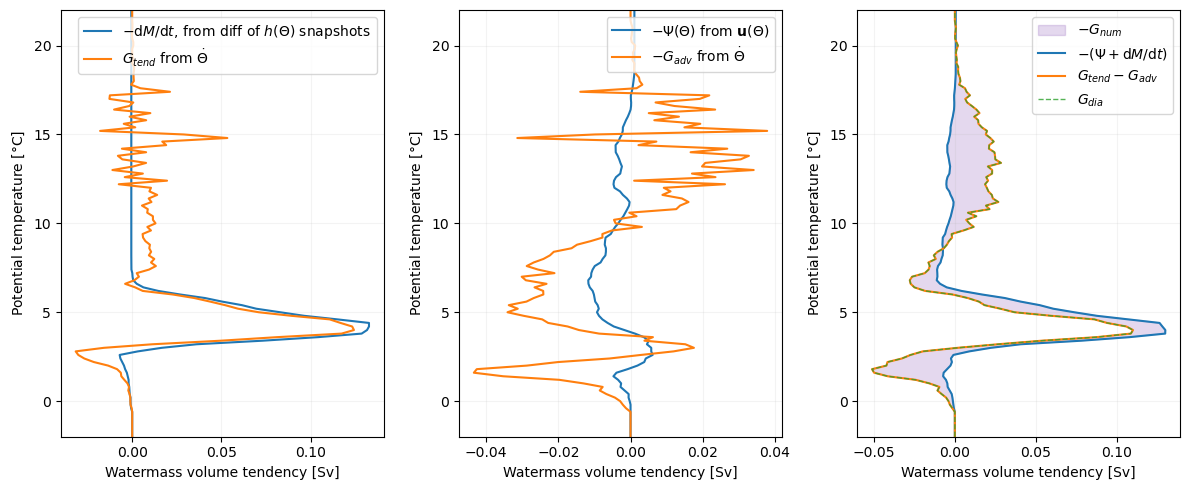

In [232]:
xwmb.wmb.plot_wmb(wmb_polygon, ylim=[-2, 22])

In [187]:
wmb_polygon['G_snm'] = -(wmb_polygon['Psi'] + wmb_polygon['dMdt']) - wmb_polygon['G_dia']

(-2.0, 20.0)

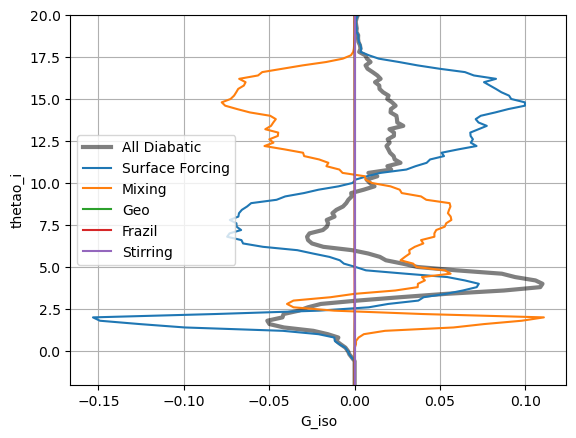

In [233]:
rho0 = 1035.
( wmb_polygon['G_dia'].mean('time')  / rho0*1e-6 ).plot(color="k", y="thetao_i", label="All Diabatic", alpha=0.5, lw=3)
( wmb_polygon['G_surf'].mean('time')  / rho0*1e-6 ).plot(y="thetao_i", label="Surface Forcing")
( wmb_polygon['G_mix'].mean('time')  / rho0*1e-6 ).plot(y="thetao_i", label="Mixing")
( wmb_polygon['G_geo'].mean('time')  / rho0*1e-6 ).plot(y="thetao_i", label="Geo")
( wmb_polygon['G_ice'].mean('time')  / rho0*1e-6 ).plot(y="thetao_i", label="Frazil")
( wmb_polygon['G_iso'].mean('time')  / rho0*1e-6 ).plot(y="thetao_i", label="Stirring")
plt.legend()
plt.grid(True)
plt.ylim(-2, 20)

(-2.0, 20.0)

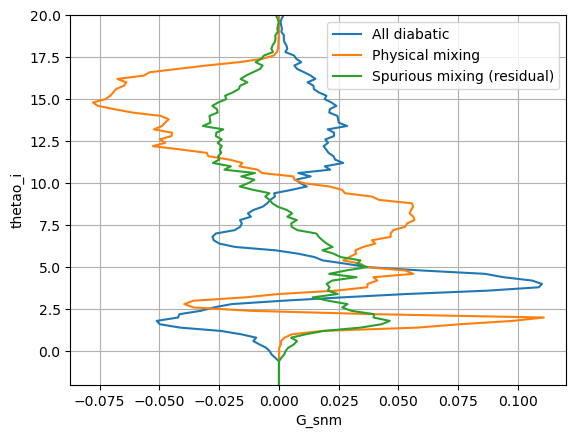

In [234]:
( wmb_polygon['G_dia'].mean('time')  / rho0*1e-6 ).plot(y="thetao_i", label="All diabatic")
( wmb_polygon['G_mix'].mean('time')  / rho0*1e-6 ).plot(y="thetao_i", label="Physical mixing")
( wmb_polygon['G_snm'].mean('time')  / rho0*1e-6 ).plot(y="thetao_i", label="Spurious mixing (residual)")
plt.legend()
plt.grid(True)
plt.ylim(-2, 20)